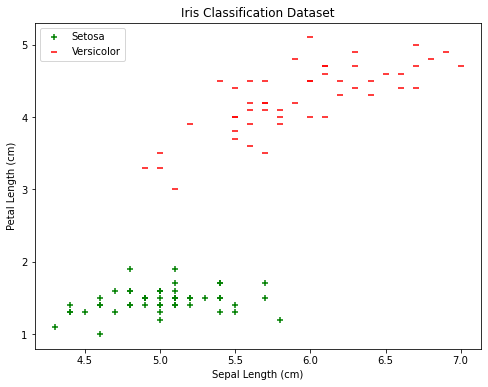

     pcost       dcost       gap    pres   dres
 0: -2.0723e+01 -3.5810e+01  3e+02  2e+01  2e+00
 1: -2.8720e+01 -1.3230e+01  7e+01  4e+00  5e-01
 2: -1.3389e+00 -5.8475e-02  4e+00  2e-01  3e-02
 3: -7.7275e-02 -2.0677e-02  2e-01  1e-02  1e-03
 4: -7.6591e-03 -1.6584e-02  9e-03  2e-17  8e-15
 5: -1.2257e-02 -1.3667e-02  1e-03  2e-18  2e-15
 6: -1.3522e-02 -1.3549e-02  3e-05  3e-18  2e-15
 7: -1.3546e-02 -1.3546e-02  3e-07  2e-18  3e-15
 8: -1.3546e-02 -1.3546e-02  3e-09  2e-18  2e-15
Optimal solution found.


C:\Users\joero\AppData\Local\Temp/ipykernel_26568/1209210909.py:164: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(multipliers[i] * y[i] * np.array(X)[i] for i in range(len(y)))


Model accuracy score with default hyperparameters: 1.0000


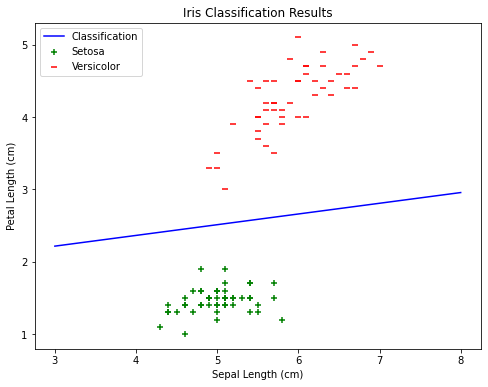

Training-set accuracy score: 1.0000
Confusion matrix

 [[7 0]
 [0 3]]

True Positives(TP)  =  7

True Negatives(TN)  =  3

False Positives(FP) =  0

False Negatives(FN) =  0


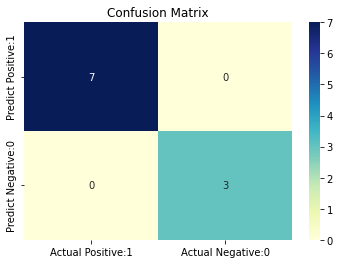

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Classification accuracy : 1.0000
Classification error : 0.0000
Precision : 1.0000
Sensitivity : 1.00
Specificity : 1.0
True Positive Rate : 1.00
False Positive Rate : 0.00
ROC AUC : 1.0000
Elapsed time: 19.376285 seconds.



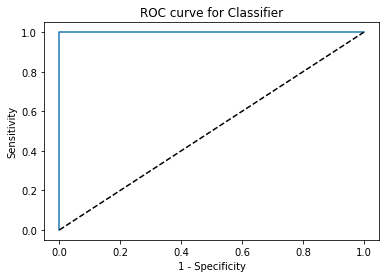

In [3]:
# Full script for report 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import time
import cvxopt.solvers
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Timer functions to determine CPU time
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)
    
tic()
df = pd.read_csv('../COMP0120-Numerical-Optimisation-Coursework-2-Report/Iris.csv')

df = df.drop(['Id'],axis=1)
target = df['Species']
s = set()
for val in target:
    s.add(val)
s = list(s)
rows = list(range(100,150))
df = df.drop(df.index[rows])

x = df['SepalLengthCm']
y = df['PetalLengthCm']

setosa_x = x[:50]
setosa_y = y[:50]

versicolor_x = x[50:]
versicolor_y = y[50:]

plt.figure(figsize=(8,6))
plt.scatter(setosa_x,setosa_y,marker='+',color='green', label = 'Setosa')
plt.scatter(versicolor_x,versicolor_y,marker='_',color='red', label = 'Versicolor')
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Petal Length (cm)")
plt.title('Iris Classification Dataset')
plt.legend()
plt.show()

# Drop rest of the features and extract the target values
df = df.drop(['SepalWidthCm','PetalWidthCm'],axis=1)
Y = []
target = df['Species']
for val in target:
    if(val == 'Iris-setosa'):
        Y.append(-1)
    else:
        Y.append(1)
df = df.drop(['Species'],axis=1)
X = df.values.tolist()
# Shuffle and split the data into training and test set
# using Train test split
X, Y = shuffle(X,Y)
# Initialise empty matrix 
x_train = []
y_train = []
x_test  = []
y_test  = []

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.9)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test  = np.array(x_test)
y_test  = np.array(y_test)

def hard_constraint_satisfied(w, b, x, y):
    return y * (np.dot(w, x) + b) >= 1

def soft_constraint_satisfied(w, b, x, y, zeta):
    return y * (np.dot(w, x) + b) >= 1 - zeta
# Transform a two-dimensional vector x into a three-dimensional vector, for 
# non-linearly seperarble data

def transform2Dto3D(X):
    return [X[0] ** 2, np.sqrt(2) * X[0] * X[1], X[1] ** 2]

# Kernal trick computes dot product without transforming vectors
# and is less computatinoally demanding
# Option for polynomial kernel
def kernel(name, x, y): 
    if name == 'linear':
        return np.dot(x, y) 
    if name == 'poly':
        return (1 + np.dot(x, y)) ** 3
def fit(X, y, w, b, lr, lambda_param, n_iters, kernel_name= 'linear'):
    n_samples, n_features = X.shape
    y_ = np.where(y <= 0, -1, 1)
    w = np.zeros(n_features)
    b = 0

    for i in range(n_iters): #_
        for j, x_i in enumerate(X):
            condition = y_[j] * (kernel(kernel_name, x_i, w) - b) >= 1 # hard constraint
            if condition:
                w -= lr * (2 * lambda_param * w)
            else:
                w -= lr * (2 * lambda_param * w - np.dot(x_i, y_[j]))
                b -= lr * y_[j]
    return w, b;

def predict(X, w, b, kernel_name):
    return np.sign(kernel(kernel_name, X, w) - b)

# Calculate the Gram matrix, 
# the matrix of all possible dot products of vectors X
def getGramMatrix(X):
    m = np.array(X).shape[0]
    K = np.array([np.dot(X[i],X[j])  for j in range(m)
              for i in range(m)]).reshape((m, m))
    return K, m;

def getEqualityConstraints(X, Y):
    m = np.array(X).shape[0]
    A = cvxopt.matrix(Y, (1, m))
    b = cvxopt.matrix(0.0)
    return A,b;

# Inequality Constraints
def getInequalityConstraints(X):
    m = np.array(X).shape[0]
    G = cvxopt.matrix(np.diag(-1 * np.ones(m)))
    h = cvxopt.matrix(np.zeros(m))
    return G, h;

def solver(P,q, A, b, G, h):
    return cvxopt.solvers.qp(P, q, G, h, A, b)

def getLagrangeMultipliers(solution):
    return np.ravel(solution['x'])

def compute_w(multipliers, X, y):
    
    return np.sum(multipliers[i] * y[i] * np.array(X)[i] for i in range(len(y))) 

def compute_b(w, X, y):
    return np.sum([y[i] - np.dot(w, X[i]) for i in range(len(X))])/len(X)

def plot(X, y, b, lambdas):
    x_min = min(X[:, 0]) - 0.5
    x_max = max(X[:, 0]) + 0.5
    y_min = min(y[:, 1]) - 0.5
    y_max = max(y[:, 1]) + 0.5
    step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    d = np.concatenate((xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)), axis=1)

    Z = b + np.sum(lambdas * y * np.dot(X, d.T), axis=0)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    sns.scatterplot(x=X[:, 0], y=y[:, 1], hue=self.y, ax=ax)
    ax.contour(xx, yy, Z, levels=[-1, 0, 1])
    plt.show()
    
# Calculate the Gram matrix, 
# the matrix of all possible dot products of vectors X
K, m = getGramMatrix(X)

# Construct vectorised version of Wolfe dual problem
# Using outer product yy^T
P = cvxopt.matrix(np.outer(y,y) * K)
q = cvxopt.matrix(-1 * np.ones(m))

A, b = getEqualityConstraints(X,Y)
#print(A.size)
A = cvxopt.matrix(A, (1, m), 'd')

G, h = getInequalityConstraints(X)


solution = solver(P,q, A, b, G, h)

multipliers = getLagrangeMultipliers(solution)

# Support vectors have positive multipliers.
has_pos_multiplier = multipliers > 1e-5

sv_multipliers = multipliers[has_pos_multiplier]

support_vectors_X = np.array(X)[has_pos_multiplier]
support_vectors_Y = np.array(Y)[has_pos_multiplier]  

# Calculate w with sv and without
w = compute_w(multipliers, X, Y)
w_from_sv = compute_w(sv_multipliers, support_vectors_X, support_vectors_Y)
#print(np.array(X).shape)

# Compute b for each X
b = compute_b(w, support_vectors_X, support_vectors_Y)

# # Soft margin constraints 
# print("Hard constraint satisfied?")
# print(hard_constraint_satisfied(w, b, x, y), "\n")

# print("Soft constraint satisfied?")
# print(soft_constraint_satisfied(w, b, x, y, zeta=2)) 


# Fit classifier to training set
[w, b] = fit(x_train, y_train, None, None, 0.001, 0.01, 10000, 'linear')

# Make predictions on test set
y_pred = predict(x_test, w, b, 'linear')
y_pred_test = predict(x_test, w, b, 'linear')

# Compute and print accuracy score
# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

x_points = np.linspace(3, 8)    # generating x-points from 3 to 8
y_points = -(w[0] / w[1]) * x_points + b / w[1]  

plt.figure(figsize=(8,6))
plt.scatter(setosa_x,setosa_y,marker='+',color='green', label = 'Setosa')
plt.scatter(versicolor_x,versicolor_y,marker='_',color='red', label ='Versicolor')
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Petal Length (cm)")
plt.title('Iris Classification Results')
plt.plot(x_points, y_points, c='b', label = 'Classification');
plt.legend()
plt.show()

# Compare train set and test set accuracy
y_pred_train = predict(x_train, w, b, 'linear')
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


cm = confusion_matrix(y_test, y_pred_test)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP)  = ', TP)
print('\nTrue Negatives(TN)  = ', TN)
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                  index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_test))

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

# Precision score
precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))
# Sensitivity and specificity
sensitivity = TP / float(TP + FN)
specificity = TN / (TN + FP)
print('Sensitivity : {0:0.2f}'.format(sensitivity))
print('Specificity : {0:0.2}'.format(specificity))

true_positive_rate = TP / float(TP + FN)
false_positive_rate = FP / float(FP + TN)

print('True Positive Rate : {0:0.2f}'.format(true_positive_rate))
print('False Positive Rate : {0:0.2f}'.format(false_positive_rate))
# ROC Curve 
false_pos_rate, true_pos_rate, thres = roc_curve(y_test, y_pred_test)

plt.plot(false_pos_rate, true_pos_rate)
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for Classifier')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

#Compute ROC AUC
ROC_AUC = roc_auc_score(y_test, y_pred_test)
print('ROC AUC : {:.4f}'.format(ROC_AUC))
toc()